In [1]:
import numpy as np
import pandas as pd
import os
import time
from numpy import sqrt
from numpy import argmax

# Handle missing values
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN 

# Data scaling
from sklearn import preprocessing

# Split data
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBRegressor
import catboost
from catboost import CatBoostRegressor

# Feature selection
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Hyperparameter tuning
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy import stats

# Analysis
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report

# Visualisation
import seaborn as sb
from pandas.plotting import scatter_matrix
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

Using TensorFlow backend.


In [2]:
# Read train and test datasets

all_features = pd.Series([
    'age', 'class of worker', 'detailed industry code', 'detailed occupation code', 'education', 'wage per hour', 'enroll in edu inst last wk',
    'marital status', 'major industry', 'major occupation', 'race', 'hispanic origin', 'sex', 'member of a labor union',
    'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks',
    'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat',
    'detailed household summary in household', 'instance weight', 'migration code-change in msa', 'migration code-change in reg',
    'migration code-move within reg', 'lived in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer',
    'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship',
    'own business or self employed', 'fill inc questionnaire for veterans admin', 'veterans benefits', 'weeks worked in year',
    'year', 'income class'
])

# Read training and test datasets
train_data_unprocessed = pd.read_csv('/kaggle/input/ml-challenge-week6/census-income.data', names=all_features, sep=' *, *', na_values='?', engine='python')
test_data_unprocessed = pd.read_csv('/kaggle/input/ml-challenge-week6/census-income.test', names=all_features, sep=' *, *', na_values='?', engine='python')
assert len(all_features) == len(train_data_unprocessed.columns) == len(test_data_unprocessed.columns), 'Invalid number of columns'

In [3]:
# Handle missing data
# https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779
# Columns with missing values: 'class of worker', 'enroll in edu inst last wk', 'major occupation', 'hispanic origin', 'member of a labor union', 
# 'reason for unemployment', 'region of previous residence', 'state of previous residence', 'migration code-change in msa', 'migration code-change in reg', 
# 'migration code-move within reg', 'migration prev res in sunbelt', 'family members under 18', 'country of birth father', 'country of birth mother', 
# 'country of birth self', 'fill inc questionnaire for veterans admin'
train_data_no_missing_data = train_data_unprocessed.copy()
test_data_no_missing_data = test_data_unprocessed.copy()

# Optional - Replace 'Not in universe'
train_data_no_missing_data = train_data_no_missing_data.replace('Not in universe', np.nan)
test_data_no_missing_data = test_data_no_missing_data.replace('Not in universe', np.nan)

train_data_no_missing_data.replace('?', np.nan, inplace=True)
assert train_data_no_missing_data.where(train_data_no_missing_data == '?').any().sum() == 0, "Unexpected value in dataset"
assert test_data_no_missing_data.where(test_data_no_missing_data == '?').any().sum() == 0, "Unexpected value in dataset"

# Optional - remove columns with missing data above threashold
# Note: columns with missing data are removed further down
# train_data_no_missing_data = train_data_no_missing_data.loc[:, train_data_no_missing_data.isnull().mean() < .001]
# test_data_no_missing_data = test_data_no_missing_data.loc[:, test_data_no_missing_data.isnull().mean() < .001]

# Fill missing values
train_data_no_missing_data = train_data_no_missing_data.fillna("Unknown")
test_data_no_missing_data = test_data_no_missing_data.fillna("Unknown")
assert train_data_no_missing_data.isnull().values.sum() == 0, "Training dataset should not have any nan values"
assert test_data_no_missing_data.isnull().values.sum() == 0, "Test dataset should not have any nan values"

/opt/conda/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [4]:
# Drop duplicates - training dataset only
# Number of instances data = 199523, Duplicate or conflicting instances : 46716
# Number of instances in test = 99762, Duplicate or conflicting instances : 20936
# Note: For this challenge, the test dataset must not be altered
nr_train_data_before = train_data_no_missing_data.shape
train_data_no_duplicates = train_data_no_missing_data.drop_duplicates(keep=False, inplace=False)
test_data_no_duplicates = test_data_no_missing_data
print("Duplicate training dataset rows removed: ", nr_train_data_before[0] - train_data_no_duplicates.shape[0])

Duplicate training dataset rows removed:  5995


In [5]:
# Feature Selection
# MSA: https://en.wikipedia.org/wiki/List_of_metropolitan_statistical_areas

# Option 1: Features opt-out
features_to_drop = [
 
    # ====== Missing data cleanup ======
    
    # Feature clenaup > 70% missing data
    
    'family members under 18', # Diff: 0.08
    'fill inc questionnaire for veterans admin',
    'enroll in edu inst last wk', # Diff: 0.05
    'migration prev res in sunbelt',
    'region of previous residence', 'state of previous residence',
    'member of a labor union', # Diff: 0.02
    
    # Feature cleanup > 50% missing data
    
    'major occupation', # Diff: 0.21
    'migration code-change in reg',
    'migration code-move within reg',
    
     # Feature cleanup 0.001% < missing data % < 0.1%
    
    'country of birth self', 'country of birth mother', 'country of birth father',
    'hispanic origin', # Diff: 0.04

    # ====== High predictive power ======
    
#     'class of worker', # Diff: 0.25
    
#     'education' Diff: 0.21
    
    # Occupation & industry: 
    'major industry', 
#     'detailed occupation code', 'detailed industry code',
    
#     'dividends from stocks', # Diff: 0.21
    
#     #  Business owner: Diff: 0.15
    'own business or self employed',
    
#     # 'age' Diff: 0.12

#     # Status: 
#      'marital status', # Diff: 0.10
    'detailed household summary in household', # Diff: 0.10
#     'tax filer stat', # Diff: 0.06
    'detailed household and family stat',
    
#     # ====== Medium predictive power ======
            
#     # Employment
#     'reason for unemployment',
    'full or part time employment stat', # Diff: 0.08
            
#     # Veteran
#     'veterans benefits', # Diff: 0.08
                      
#     'race', 'sex', # Diff: 0.06
        
#     # ====== Low predictive power ======
        
#     # Citizenship: 
#     'citizenship', # Diff: 0.04
        
#     # Has moved: 
#     'migration code-change in msa', 'lived in this house 1 year ago', # Diff: 0.03
            
    # ====== Other features ======
    
    # wage per hour, weeks worked in year
    
    # Not relevant
    'year'
]

# Option 2: Features opt-in
# feature_to_use = [
#     'age', 'class of worker', 'education', 'marital status', 'major occupation', 'race', 'sex',
#     'capital gains', 'capital losses', 'wage per hour', 'weeks worked in year', 'citizenship'
# ]
# features_to_drop = [x for x in all_features if x not in feature_to_use]

train_data_selected = train_data_no_duplicates.copy()
test_data_selected = test_data_no_duplicates.copy()

selected_features = [x for x in all_features if x not in features_to_drop]
print("Nr of selected features:", len(selected_features))
train_data_selected = train_data_selected.drop(features_to_drop, axis=1)
test_data_selected = test_data_selected.drop(features_to_drop, axis=1)
assert len(selected_features) == len(train_data_selected.columns) == len(test_data_selected.columns), 'Unexpected number of features'

Nr of selected features: 22


In [6]:
# Feature engineering
X_train_engineered = train_data_selected.copy()
test_data_engineered = test_data_selected.copy() 
engineered_features = selected_features.copy()

# ============ Collapse states ============ 

# Collapse age and remove minors - very slightly decreases performance
# X_train_engineered['age'] = X_train_engineered['age'].div(10).round()
# test_data_engineered['age'] = test_data_engineered['age'].div(10).round()

# Collapse marrital status
print("Marrital status:", set(X_train_engineered["marital status"]))
marrital_status_single = ['Never married', 'Separated', 'Divorced', 'Widowed']
marrital_status_married = ['Married-civilian spouse present', 'Married-spouse absent', 'Married-A F spouse present']
X_train_engineered["marital status"] = X_train_engineered["marital status"].replace(marrital_status_single, 'Single')
test_data_engineered["marital status"] = test_data_engineered["marital status"].replace(marrital_status_single, 'Single')
X_train_engineered["marital status"] = X_train_engineered["marital status"].replace(marrital_status_married, 'Married')
test_data_engineered["marital status"] = test_data_engineered["marital status"].replace(marrital_status_married, 'Married')
print("Updated marrital status:", set(X_train_engineered["marital status"]))

# Citizenship: US vs non-US - degrades performance
# us_citizen = ['Foreign born- U S citizen by naturalization', 'Native- Born abroad of American Parent(s)', 'Native- Born in the United States']
# non_us_citizen = ['Foreign born- Not a citizen of U S', 'Native- Born in Puerto Rico or U S Outlying']
# X_train_engineered["citizenship"] = X_train_engineered["citizenship"].replace(non_us_citizen, 0)
# X_train_engineered["citizenship"] = X_train_engineered["citizenship"].replace(us_citizen, 1)
# test_data_engineered["citizenship"] = test_data_engineered["citizenship"].replace(non_us_citizen, 0)
# test_data_engineered["citizenship"] = test_data_engineered["citizenship"].replace(us_citizen, 1)
# print("\nCitizenship:")
# print(test_data_engineered['citizenship'].value_counts())

# Country of birth self - degrades performance
# X_train_engineered.loc[~X_train_engineered["country of birth self"].isin(['United-States']), "country of birth self"] = 0
# X_train_engineered.loc[X_train_engineered["country of birth self"].isin(['United-States']), "country of birth self"] = 1
# test_data_engineered.loc[~test_data_engineered["country of birth self"].isin(['United-States']), "country of birth self"] = 0
# test_data_engineered.loc[test_data_engineered["country of birth self"].isin(['United-States']), "country of birth self"] = 1
# print("\nCountry of birth self:")
# print(test_data_engineered['country of birth self'].value_counts())

# Collapse wage per hour - cents to dollars - degrades performance
# X_train_engineered['wage per hour'] = X_train_engineered['wage per hour'].div(100).round()
# test_data_engineered['wage per hour'] = test_data_engineered['wage per hour'].div(100).round()

# Collapse major occupation - degrades performance
# techinal_jobs = ['Craft-repair','Precision production craft & repair','Machine operators assmblrs & inspctrs']
# service_jobs = ['Other service','Private household services','Protective services','Sales']
# support_jobs = ['Adm support including clerical','Technicians and related support']
# high_level_jobs = ['Executive admin and managerial','Professional specialty']
# low_level_jobs = ['Farming forestry and fishing','Armed Forces','Handlers equip cleaners etc','Transportation and material moving']
# X_train_engineered["major occupation"] = X_train_engineered["major occupation"].replace(techinal_jobs, 'Technical')
# X_train_engineered["major occupation"] = X_train_engineered["major occupation"].replace(service_jobs, 'Service')
# X_train_engineered["major occupation"] = X_train_engineered["major occupation"].replace(support_jobs, 'Support')
# X_train_engineered["major occupation"] = X_train_engineered["major occupation"].replace(high_level_jobs, 'High-level')
# X_train_engineered["major occupation"] = X_train_engineered["major occupation"].replace(low_level_jobs, 'Low-level')
# test_data_engineered["major occupation"] = test_data_engineered["major occupation"].replace(techinal_jobs, 'Technical')
# test_data_engineered["major occupation"] = test_data_engineered["major occupation"].replace(service_jobs, 'Service')
# test_data_engineered["major occupation"] = test_data_engineered["major occupation"].replace(support_jobs, 'Support')
# test_data_engineered["major occupation"] = test_data_engineered["major occupation"].replace(high_level_jobs, 'High-level')
# test_data_engineered["major occupation"] = test_data_engineered["major occupation"].replace(low_level_jobs, 'Low-level')
# print("\nHigh level job:")
# print(test_data_engineered['major occupation'].value_counts())

# Household summary: Householder vs non-householder
# X_train_engineered.loc[~X_train_engineered["detailed household summary in household"].isin(['Householder']), "detailed household summary in household"] = 0
# X_train_engineered.loc[X_train_engineered["detailed household summary in household"].isin(['Householder']), "detailed household summary in household"] = 1
# test_data_engineered.loc[~test_data_engineered["detailed household summary in household"].isin(['Householder']), "detailed household summary in household"] = 0
# test_data_engineered.loc[test_data_engineered["detailed household summary in household"].isin(['Householder']), "detailed household summary in household"] = 1
# print("\nHousehold summary:")
# print(test_data_engineered['detailed household summary in household'].value_counts())

# Collapse dividends from stocks
# X_train_engineered.loc[X_train_engineered["dividends from stocks"] > 0, "dividends from stocks"] = 1
# test_data_engineered.loc[test_data_engineered["dividends from stocks"] > 0, "dividends from stocks"] = 1
# print("\nDividents from stocks:")
# print("No dividents:",len(test_data_engineered[test_data_engineered['dividends from stocks'] == 0]))
# print("Dividents:",len(test_data_engineered[test_data_engineered['dividends from stocks'] > 0]))

# ============ Add features ============ 

# Addd 'is highly educated'
engineered_features = np.concatenate([engineered_features, ['is highly educated']])
is_highly_educated = ['Associates degree-academic program', 'Associates degree-occup /vocational', 'Bachelors degree(BA AB BS)', 'Doctorate degree(PhD EdD)',
                      'High school graduate', 'Masters degree(MA MS MEng MEd MSW MBA)', 'Prof school degree (MD DDS DVM LLB JD)', 'Some college but no degree']
# is_highly_educated = ['Bachelors degree(BA AB BS)', 'Doctorate degree(PhD EdD)', 'Masters degree(MA MS MEng MEd MSW MBA)', 'Prof school degree (MD DDS DVM LLB JD)']
X_train_engineered.loc[~X_train_engineered["education"].isin(is_highly_educated), "is highly educated"] = 0
X_train_engineered.loc[X_train_engineered["education"].isin(is_highly_educated), "is highly educated"] = 1
test_data_engineered.loc[~test_data_engineered["education"].isin(is_highly_educated), "is highly educated"] = 0
test_data_engineered.loc[test_data_engineered["education"].isin(is_highly_educated), "is highly educated"] = 1
print("\nEducation:")
print(test_data_engineered['is highly educated'].value_counts())

# No salary - degrades performance
# engineered_features = np.concatenate([engineered_features, ['no salary']])
# X_train_engineered.loc[X_train_engineered["class of worker"].isin(['Never worked', 'Without pay']), "no salary"] = 1
# X_train_engineered.loc[~X_train_engineered["class of worker"].isin(['Never worked', 'Without pay']), "no salary"] = 0
# test_data_engineered.loc[test_data_engineered["class of worker"].isin(['Never worked', 'Without pay']), "no salary"] = 1
# test_data_engineered.loc[~test_data_engineered["class of worker"].isin(['Never worked', 'Without pay']), "no salary"] = 0
# print("\nNo salary:")
# print(test_data_engineered['no salary'].value_counts())

# Both monthly wage and weeks worked in year are available, but the data is incomplete
# engineered_features = np.concatenate([engineered_features, ['yearly income']])
# X_train_engineered['yearly income'] = (X_train_engineered['wage per hour'] * X_train_engineered['weeks worked in year']).multiply(8).multiply(5).div(10000).round()
# test_data_engineered['yearly income'] = (test_data_engineered['wage per hour'] * test_data_engineered['weeks worked in year']).multiply(8).multiply(5).div(10000).round()
# X_train_engineered.loc[X_train_engineered["yearly income"].between(0, 5, inclusive=False), "yearly income"] = 1
# X_train_engineered.loc[X_train_engineered["yearly income"] >= 5, "yearly income"] = 2
# test_data_engineered.loc[test_data_engineered["yearly income"].between(0, 5, inclusive=False), "yearly income"] = 1
# test_data_engineered.loc[test_data_engineered["yearly income"] >= 5, "yearly income"] = 2
# print("\nYearly income:")
# print(test_data_engineered['yearly income'].value_counts())
                                          
# Merge capital gains and capital loss fields, they are exclusive
assert len(X_train_engineered[(X_train_engineered['capital gains'] != 0) & (X_train_engineered['capital losses'] != 0)]) == 0, "Expecting no entries with both capital gains and capital losses"
engineered_features = np.concatenate([engineered_features, ['capital gains loss']])
X_train_engineered['capital gains loss'] = X_train_engineered['capital gains'] - X_train_engineered['capital losses']
test_data_engineered['capital gains loss'] = test_data_engineered['capital gains'] - test_data_engineered['capital losses']

features_to_drop = [ 
    'capital gains', 'capital losses',
#     'major occupation',
#     'country of birth self',
#     'wage per hour', 'weeks worked in year'
#     'class of worker',
]
engineered_features = [x for x in engineered_features if x not in features_to_drop]
X_train_engineered = X_train_engineered.drop(features_to_drop, axis=1)
test_data_engineered = test_data_engineered.drop(features_to_drop, axis=1)
print("\nEngineered features:", len(engineered_features))
assert len(engineered_features) == len(X_train_engineered.columns) == len(test_data_engineered.columns), 'Unexpected number of features'

Marrital status: {'Married-civilian spouse present', 'Divorced', 'Widowed', 'Separated', 'Never married', 'Married-A F spouse present', 'Married-spouse absent'}
Updated marrital status: {'Married', 'Single'}

Education:
1.0    57557
0.0    42205
Name: is highly educated, dtype: int64

Engineered features: 22


In [7]:
# Encode categories
# https://towardsdatascience.com/encoding-categorical-features-21a2651a065c
# https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd

encoder = preprocessing.LabelEncoder()
X_train_encoded = X_train_engineered.copy()
test_data_encoded = test_data_engineered.copy()
combined_data = pd.concat([X_train_encoded, test_data_encoded]) # The encoder should be fitted using both train and test datasets.

X_train_encoded['income class'] = X_train_encoded['income class'].map({'- 50000.': 0, '50000+.': 1})

label_encoding = { }
for feature in engineered_features:      
    if X_train_encoded[feature].dtype == "object":
        encoder.fit(combined_data[feature].astype(str))
        X_train_encoded[feature] = encoder.transform(X_train_encoded[feature].astype(str))
        label_encoding[feature] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    if test_data_encoded[feature].dtype == "object":
        encoder.fit(combined_data[feature].astype(str))
        test_data_encoded[feature] = encoder.transform(test_data_encoded[feature].astype(str))

In [8]:
# Visualise correlations between features and income class

# Veteran benefits
# g = sb.factorplot(x="veterans benefits", y="income class", data=X_train_encoded, kind="bar", height = 10, palette = "muted")
# g.despine(left=True)
# g = g.set_ylabels("Income >50K Probability")
# plt.show()

# enroll in edu inst last wk
# g = sb.factorplot(x="enroll in edu inst last wk", y="income class", data=X_train_encoded, kind="bar", height = 10, palette = "muted")
# g.despine(left=True)
# g = g.set_ylabels("Income >50K Probability")
# plt.show()

# Has moved: lived in this house 1 year ago
# print(label_encoding['lived in this house 1 year ago'])
# g = sb.factorplot(x="lived in this house 1 year ago", y="income class", data=X_train_encoded, kind="bar", height = 10, palette = "muted")
# g.despine(left=True)
# g = g.set_ylabels("Income >50K Probability")
# plt.show()

# 'detailed household summary in household',
# print(label_encoding['detailed household summary in household'])
# g = sb.factorplot(x="detailed household summary in household", y="income class", data=X_train_encoded, kind="bar", height = 10, palette = "muted")
# g.despine(left=True)
# g = g.set_ylabels("Income >50K Probability")
# plt.show()

# Citizenship
# g = sb.factorplot(x="citizenship", y="income class", data=X_train_encoded, kind="bar", height = 10, palette = "muted")
# g.despine(left=True)
# g = g.set_ylabels("Income >50K Probability")
# plt.show()

# Major occupation
# print(label_encoding['major occupation'])
# g = sb.factorplot(x="major occupation", y="income class", data=X_train_encoded, kind="bar", height = 10, palette = "muted")
# g.despine(left=True)
# g = g.set_ylabels("Income >50K Probability")
# plt.show()

# Class of worker
# print(label_encoding['class of worker'])
# X_train_encoded.groupby(["income class", "class of worker"]).size().unstack("income class").plot(kind="bar",fontsize=14, figsize=(10,10))

# print(label_encoding['education'])
# X_train_encoded[['education','income class']].groupby(['education']).mean()

# Explore Education vs Income
# print(label_encoding['education'])
# g = sb.factorplot(x="education", y="income class", data=X_train_encoded, kind="bar", height = 10, palette = "muted")
# g.despine(left=True)
# g = g.set_ylabels(">50K probability")

# # Explore Age vs Income
# g = sb.FacetGrid(X_train_encoded, col='income class', height=10)
# g = g.map(sb.distplot, "age")
# plt.show()

# # Explore detailed household summary in household vs Income
# print(label_encoding['tax filer stat'])
# g = sb.factorplot(x="tax filer stat", y="income class", data=X_train_encoded, kind="bar", height = 10, palette = "muted")
# g.despine(left=True)
# g = g.set_ylabels("Income >50K Probability")
# plt.show()

# Explore wage per hour
# g = sb.factorplot(x="wage per hour", y="income class", data=X_train_encoded, kind="bar", height = 15, palette = "muted")
# g.despine(left=True)
# g = g.set_ylabels("Income >50K Probability")
# plt.show()

# # Explore Marital Status vs Income
# print(label_encoding['marital status'])
# g = sb.factorplot(x="marital status", y="income class", data=X_train_encoded, kind="bar", height = 10, palette = "muted")
# g.despine(left=True)
# g = g.set_ylabels("Income >50K Probability")
# plt.show()

# Explore class of worker vs Income
# print(label_encoding['class of worker'])
# g = sb.factorplot(x="class of worker", y="income class", data=X_train_encoded, kind="bar", height = 6, palette = "muted")
# g.despine(left=True)
# g = g.set_ylabels("Income >50K Probability")
# plt.show()

In [9]:
# Prepare training and test datasets
# 'income class' should be used for validation, not for classification
# Note: This cannot be done before duplicate entries are removed
train_data = X_train_encoded.copy()
test_data = test_data_encoded.copy()
y = train_data['income class']

features = [x for x in engineered_features if x not in ['income class']]
train_data = train_data.drop(['income class'], axis=1)
test_data = test_data.drop(['income class'], axis=1)
assert len(features) == len(train_data.columns) == len(test_data.columns), "Unexpected number of features"

# Split training dataset
# Stratify: training and test datasets are in the same proportion as the whole dataset
X_train, X_validation, y_train, y_validation = train_test_split(train_data, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
# Handling unbalanced datasets

X_train = X_train.copy()
y_train = y_train.copy()

# Option 1: Upsample minority
# negative = train_data[train_data['income class'] == 0]
# positive = train_data[train_data['income class'] == 1]
# pos_upsampled = resample(positive,
#                          replace=True,
#                          n_samples=len(negative), # match number in majority class
#                          random_state=42)
# train_data = pd.concat([negative, pos_upsampled])
# print(train_data['income class'].value_counts())

# Option 2: Downsample majority
# negative = train_data[train_data['income class'] == 0]
# positive = train_data[train_data['income class'] == 1]
# neg_downsampled = resample(negative, 
#                            replace=False,            
#                            n_samples=len(positive),  # match number in minority class
#                            random_state=42)          
# train_data = pd.concat([positive, neg_downsampled])
# print(train_data['income class'].value_counts())

# Option 3: SMOTE
# sm = SMOTE(random_state = 42)
# X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

# Option 4: SMOTE & RandomUnderSampler
# sm = SMOTE(sampling_strategy=0.1, random_state=42)
# X_train, y_train = sm.fit_sample(X_train, y_train)
# over = SMOTE(sampling_strategy=0.1)
# from imblearn.under_sampling import RandomUnderSampler
# under = RandomUnderSampler(random_state=42)
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)
# X_train, y_train = pipeline.fit_resample(X_train, y_train)

# Option 5: ADASYN
# adasym = ADASYN(random_state=42)
# X_train, y_train = adasym.fit_sample(X_train, y_train)

# # Option 6: SMOTETomek
# from imblearn.combine import SMOTETomek
# smt = SMOTETomek()
# X_train, y_train = smt.fit_sample(X_train, y_train)

# 'sample weight' should be as input when training the models, but not as a feature
sample_weight_train = X_train['instance weight']
sample_weight_validation = X_validation['instance weight']
assert len(sample_weight_train) == len(X_train), "Nr of sample weights does not match the nr of samples"

features = [x for x in features if x not in ['instance weight']]
X_train = X_train.drop(['instance weight'], axis=1)
X_validation = X_validation.drop(['instance weight'], axis=1)
test_data = test_data.drop(['instance weight'], axis=1)

Done for 1 features
Done for 2 features
Done for 3 features
Done for 4 features
Done for 5 features
Done for 6 features
Done for 7 features
Done for 8 features
Done for 9 features
Done for 10 features
Done for 11 features
Done for 12 features
Done for 13 features
Done for 14 features
Done for 15 features
Done for 16 features
Done for 17 features
Done for 18 features
Done for 19 features


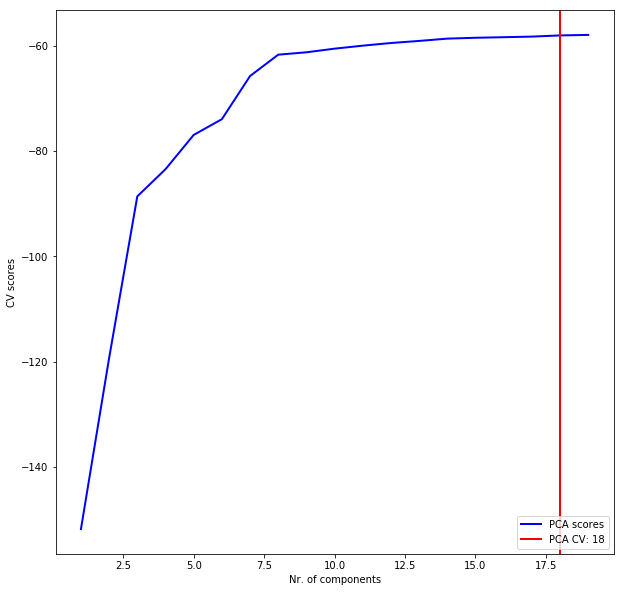

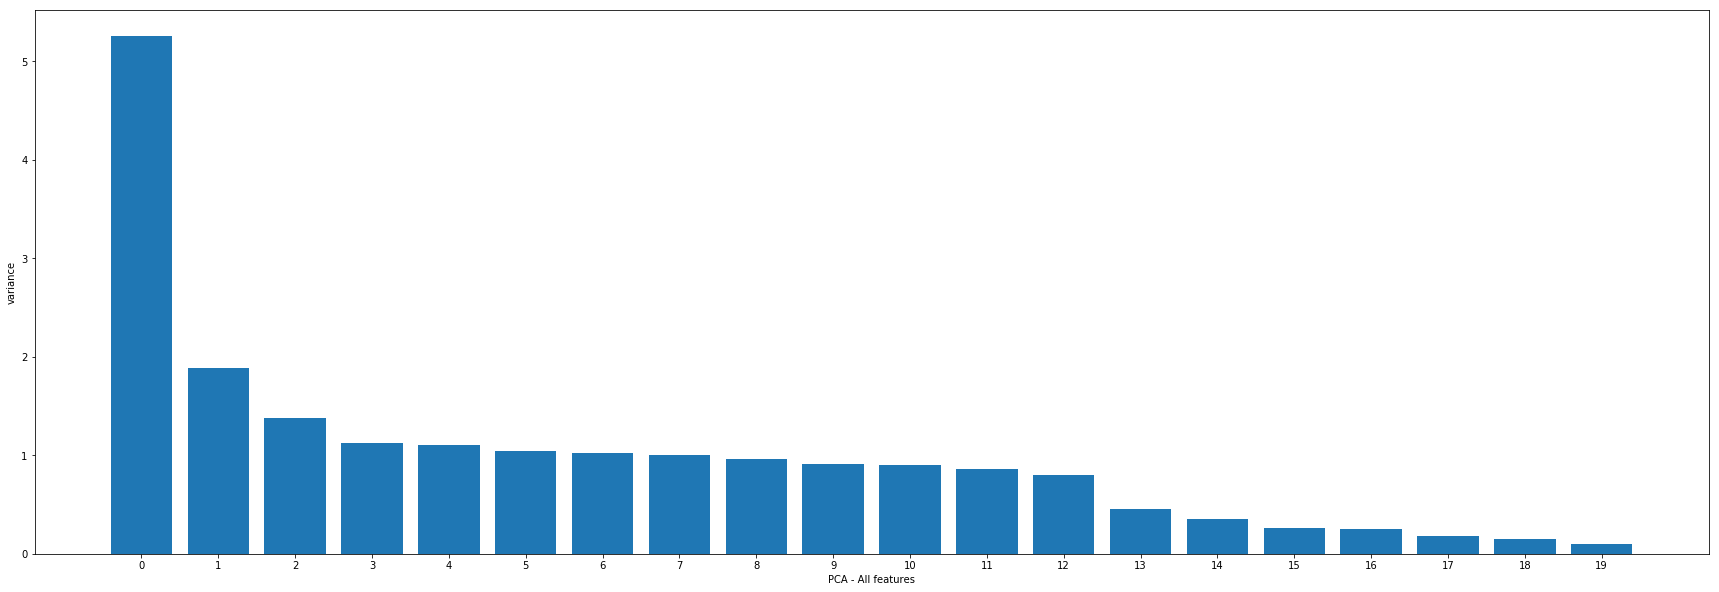

In [11]:
# # PCA

def compute_scores(X):
    pca = PCA(svd_solver='full')
    pca_scores = []
    for n in np.arange(1, len(features), 1):
        pca.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        print("Done for", n, "features")
    return pca_scores

pca_scores = compute_scores(test_data)
n_components_pca = np.argmax(pca_scores)

# Plot results
plt.figure(figsize=(10, 10))
n_components = np.arange(1, len(features), 1)  # options for n_components
plt.plot(n_components, pca_scores, 'b', label='PCA scores', linewidth=2)
plt.axvline(n_components_pca, color='r', label='PCA CV: %d' % n_components_pca, linestyle='-', linewidth=2)
plt.xlabel('Nr. of components')
plt.ylabel('CV scores')
plt.legend(loc='lower right')
plt.show()

# Plot Variance 
pca = PCA(svd_solver='full')
scaler = StandardScaler() 
pipeline = make_pipeline(scaler, pca) 
pipeline.fit(test_data)
pca_features = range(pca.n_components_) 
plt.figure(figsize=(30, 10)) 
plt.bar(pca_features, pca.explained_variance_) 
plt.xlabel('PCA - All features') 
plt.ylabel('variance') 
plt.xticks(pca_features) 
plt.show()

In [12]:
# Scale data
scaler = preprocessing.MinMaxScaler()
combined_data = pd.concat([X_train, X_validation, test_data])
scaler.fit(combined_data)
X_train = pd.DataFrame(scaler.transform(X_train), columns=features)
X_validation = pd.DataFrame(scaler.transform(X_validation), columns=features)
test_data = pd.DataFrame(scaler.transform(test_data), columns=features)

In [13]:
# Understand the data
print("Nr of features:", len(train_data.columns))
print("Train data:", X_train.shape)
print("Validation data:", X_validation.shape)
print("Test data:", test_data.shape)
print()

print("Features information:")
print()
X_train.info()

X_train.describe()

# for feature in features:
#     print(feature)
#     print(X_train[feature].value_counts())

Nr of features: 21
Train data: (154822, 20)
Validation data: (38706, 20)
Test data: (99762, 20)

Features information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154822 entries, 0 to 154821
Data columns (total 20 columns):
age                                154822 non-null float64
class of worker                    154822 non-null float64
detailed industry code             154822 non-null float64
detailed occupation code           154822 non-null float64
education                          154822 non-null float64
wage per hour                      154822 non-null float64
marital status                     154822 non-null float64
race                               154822 non-null float64
sex                                154822 non-null float64
reason for unemployment            154822 non-null float64
dividends from stocks              154822 non-null float64
tax filer stat                     154822 non-null float64
migration code-change in msa       154822 non-null float64
li

,age,class of worker,detailed industry code,detailed occupation code,education,wage per hour,marital status,race,sex,reason for unemployment,dividends from stocks,tax filer stat,migration code-change in msa,lived in this house 1 year ago,num persons worked for employer,citizenship,veterans benefits,weeks worked in year,is highly educated,capital gains loss
count,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000,154822.000000
mean,0.392469,0.624151,0.310224,0.253509,0.627924,0.005751,0.554062,0.909254,0.477910,0.985251,0.001999,0.639036,0.843461,0.666039,0.336030,0.901555,0.779909,0.459643,0.596091,0.047949
std,0.245572,0.265966,0.355555,0.316030,0.261121,0.028014,0.497070,0.217698,0.499513,0.094852,0.019724,0.279908,0.197465,0.309757,0.395976,0.281678,0.411195,0.470061,0.490681,0.045691
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.188889,0.375000,0.000000,0.000000,0.562500,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.400000,0.750000,0.500000,0.000000,1.000000,1.000000,0.000000,0.000000,0.044051
50%,0.377778,0.750000,0.039216,0.043478,0.625000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.800000,1.000000,0.500000,0.166667,1.000000,1.000000,0.230769,1.000000,0.044051
75%,0.555556,0.875000,0.647059,0.565217,0.750000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.800000,1.000000,1.000000,0.666667,1.000000,1.000000,1.000000,1.000000,0.044051
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# Feature correlation

# corr_matrix = X_train.corr(method='pearson')
# # corr_matrix = train_data_no_missing_data.corr(method='spearman')
# # corr_matrix = train_data_no_missing_data.corr(method='kendall')

# # Top correlations
# correlations = corr_matrix.abs().unstack().sort_values(kind='quicksort', ascending=False)
# correlations = correlations[(correlations>0.40) & (correlations<1.0)]
# print(correlations.head(15))

# # Plot cluster map
# sb.set(font_scale = 2)
# cmap = sb.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)
# sb.clustermap(data=corr_matrix, figsize=(30, 30), annot=True, cmap = 'coolwarm')
# # plt.savefig('clustermap.pdf')  Optional: save cluster map

In [15]:
# Build classifiers
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
# XGBoost: https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
# XGBoost handling imbalanced datasets: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
# LightGBM: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# Catboost https://towardsdatascience.com/https-medium-com-talperetz24-mastering-the-new-generation-of-gradient-boosting-db04062a7ea2
# CatBoost vs LightGBM vs XGBoost: https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db
# CatBoost examples + export to CoreML: https://catboost.ai/docs/concepts/python-usages-examples.html
classifiers = {

    # Top classifier
    "Best Classifier": XGBRegressor(eval_metric='auc', nthread=-1, random_state=42,
#                                     tree_method='gpu_hist',
                                    n_estimators=1900,
                                    learning_rate=0.01,
                                    max_depth=6,
#                                     scale_pos_weight=9.3,
#                                     subsample=0.8,
#                                     colsample_bytree= 0.3,
#                                     reg_alpha=0.5,
#                                     reg_lambda=4.5,
                                    objective='reg:logistic'),
    
    # Good classifiers
#     "XGBoost 1": XGBRegressor(eval_metric='auc', nthread=-1, random_state=42,
#                             tree_method='gpu_hist',
#                             n_estimators=500,
#                             learning_rate=0.1,
#                             max_depth=10,
#                             subsample=0.4,
#                             objective='reg:logistic'),
    
#     "Baseline XGBoost": XGBRegressor(eval_metric='auc', nthread=-1, random_state=42),
    
#     "CatBoost": CatBoostRegressor(eval_metric='AUC', thread_count=-1, silent=True, random_state=42,
#                                   task_type="GPU",
#                                   iterations=5000,
# #                                   n_estimators=1500,
#                                   learning_rate=0.01,
#                                   max_depth=6),
    
#     "CatBoost": CatBoostRegressor(silent=True, random_state=42,
#                                   task_type="GPU",
#                                   iterations=5000,
#                                   learning_rate=0.001,
#                                   max_depth=15,
#                                   eval_metric='AUC'),
    
#     "CatBoost": CatBoostRegressor(silent=True, random_state=42,
#                                   task_type="GPU",
#                                   learning_rate=0.01,
#                                   iterations=5000,
#                                   eval_metric='AUC'),
    
    # Good classifiers
#     "SGBR": GradientBoostingRegressor(max_depth=5, subsample=0.9, max_features=0.75, n_estimators=200),
#     "GBR": GradientBoostingRegressor(n_estimators=20, min_samples_split=4, max_depth=60, random_state=42),
#     "AdaBoost": AdaBoostClassifier(n_estimators=200),
#     "Bagging Classifier": BaggingClassifier(),
#     "Random Forest": RandomForestClassifier(max_depth=4, random_state=42),
    
    # Other classifiers
#     "Decision Tree": DecisionTreeClassifier(max_depth=5),
#     "Naive Bayes": GaussianNB(),
#     "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0)),
#     "Neural Net": MLPClassifier(alpha=1, max_iter=1000),
#     "QDA": QuadraticDiscriminantAnalysis()
    
    # Very long wait time
#     "Nearest Neighbors": KNeighborsClassifier(5),
#     "Linear SVM": SVC(kernel="linear", C=0.025),
#     "RBF SVM": SVC(gamma=2, C=1),
}

In [16]:
# Parameter search
# param_dist = {
# #               'n_estimators': [1600,1700,1800,1900,2000],
#               'colsample_bytree': [0.2,0.3,0.4],
# #               'subsample': [0.6,0.8,1]
# #                 'max_depth': [4,5,6],
                
# }

# clf = XGBRegressor(eval_metric='auc', nthread=-1, random_state=42,
#                    tree_method='gpu_hist',
#                    n_estimators=1900,
#                    learning_rate=0.01,
#                    max_depth=6,
#                    scale_pos_weight=9.3,
#                    subsample=0.8,
# #                  colsample_bytree= 0.3,
# #                                     subsample=1,
# #                                     reg_alpha=0.5,
# #                                     reg_lambda=4.5,
#                    objective='reg:logistic')

# kfold = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)
# clf = RandomizedSearchCV(clf, 
#                          param_distributions = param_dist,
#                          cv = kfold,
#                          n_iter = 10,
#                          scoring = 'roc_auc',
#                          error_score = 0,
#                          verbose = 3,
#                          n_jobs = -1)
# clf.fit(X_train, y_train)
# print(clf.best_params_)
# print(clf.best_score_)

In [17]:
# Train classifiers
def fit(name, classifier, X_train, y_train):
#     classifier.fit(X_train, y_train, sample_weight=sample_weight_train, early_stopping_rounds=20, eval_set=[(X_validation, y_validation)], verbose=False)
    if isinstance(classifier, CatBoostRegressor):
        cat_feature_ids = [1,2,3,4,6,7,8,9,10,12,13,14,15,16,17,18,19]   
        # cat_features must be int or string
        lst = list(X_train)
        X_train[lst] = X_train[lst].astype(str)
        X_validation[lst] = X_validation[lst].astype(str)
        test_data[lst] = test_data[lst].astype(str)
        classifier.fit(X_train, y_train, sample_weight=sample_weight_train, cat_features=cat_feature_ids, verbose=True)
    else:
        classifier.fit(X_train, y_train, sample_weight=sample_weight_train, verbose=True)

for index, (name, classifier) in enumerate(classifiers.items()):
    print("Training classifier:", name)
    start_time = time.time()
    fit(name, classifier, X_train, y_train)
    print("Done training:", time.time() - start_time, "s")

Training classifier: Best Classifier
Done training: 509.0865275859833 s


In [18]:
# Predict test results
test_predictions = { }
def predict(classifier, X_validation):
    return classifier.predict(X_validation)
#     return classifier.predict(X_validation, ntree_limit=classifier.best_ntree_limit)

for index, (name, classifier) in enumerate(classifiers.items()):
    print("Predicting results using: ", name)
    start_time = time.time()
    test_predictions[name] = predict(classifier, X_validation)
    print("Done predicting:", time.time() - start_time, "s")
    
# Select the classifier
selected_classifier = "Best Classifier"
print("Selected Classifier:", selected_classifier)
model = classifiers[selected_classifier]    
test_prediction = test_predictions[selected_classifier]

Predicting results using:  Best Classifier
Done predicting: 9.965697765350342 s
Selected Classifier: Best Classifier


Fold: 0
Fold: 1
Fold: 2


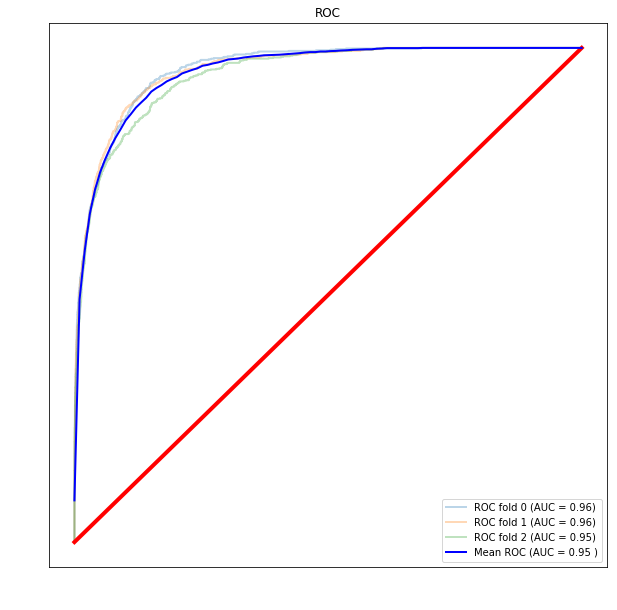

CV All thresholds [0.055533305, 0.09021734, 0.055781282]
CV Mean threshold 0.0671773
Non CV threshold=0.055781, G-Mean=0.881


In [19]:
# Plot ROC curve
# Retrieve best Threshold
# Threshold: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

# Best Classifier - ROC Curve with k-Fold CV
tprs = []
aucs = []
thresholds = []
cv = StratifiedKFold(n_splits=3)
x = X_validation
y = y_validation
mean_fpr = np.linspace(0,1,100)

plt.figure(figsize=(10, 10))
for i, (train, test) in enumerate(cv.split(x,y)):
    print("Fold:", i)
    prediction = model.predict(x.iloc[test])
    fpr, tpr, t = roc_curve(y.iloc[test], prediction)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(roc_auc)
    gmeans = sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    threshold = t[ix]
    thresholds.append(threshold)
    
plt.plot([0,1],[0,1], 'r', linewidth=4)
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr) # Plor mean auc
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.xlabel('False Positive Rate', fontsize=16, color='white')
plt.ylabel('True Positive Rate', fontsize=16, color='white')
plt.title('ROC')
plt.legend(loc="lower right")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.style.use('dark_background')
plt.show()
    
# Compare all classifiers
# labels = ["Baseline"]
# plt.figure(figsize=(10,10))
# plt.plot([0, 1], [0, 1], 'r', linewidth=4)
# for index, (name, classifier) in enumerate(classifiers.items()): 
#     labels.append(name)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_validation, test_predictions[name])
#     plt.plot(false_positive_rate, true_positive_rate, linewidth=2)
# plt.axis([0, 1, 0, 1])
# plt.xlabel('False Positive Rate (FPR)', fontsize=16, color='white')
# plt.ylabel('True Positive Rate (TPR)', fontsize=16, color='white')
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')
# plt.style.use('dark_background')
# plt.legend(labels=labels)
# plt.show()

# Select best threshold
print("CV All thresholds", thresholds)
mean_cv_threshold = np.mean(thresholds)
print("CV Mean threshold", mean_cv_threshold)
fpr, tpr, non_cv_thresholds = roc_curve(y_validation, test_prediction)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
non_cv_threshold = non_cv_thresholds[ix]
print('Non CV threshold=%f, G-Mean=%.3f' % (non_cv_threshold, gmeans[ix]))
best_threshold = non_cv_threshold

In [20]:
# ROC AUC score, MAE, MSE, classification report
# Precision: Number of true positives out of all predicted positive values
# Recall: Find all positive values

for index, (name, y_pred) in enumerate(test_predictions.items()):
    predictions = np.where(y_pred < best_threshold, 0, 1)
    print(name, 
          "Score: {0:.2f}".format(metrics.roc_auc_score(y_validation, predictions)),
          "MAE: {0:.2f}".format(mean_absolute_error(y_validation, predictions)),
          "MSE: {0:.2f}".format(mean_squared_error(y_validation, predictions)))
    print()
    print(classification_report(y_validation, predictions))
    print()
    
# Best result
# Best Classifier Score: 0.88 MAE: 0.13 MSE: 0.13

#               precision    recall  f1-score   support

#            0       0.99      0.87      0.93     36230
#            1       0.32      0.89      0.47      2476

#     accuracy                           0.87     38706
#    macro avg       0.65      0.88      0.70     38706
# weighted avg       0.95      0.87      0.90     38706

Best Classifier Score: 0.88 MAE: 0.15 MSE: 0.15

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     36230
           1       0.29      0.91      0.45      2476

    accuracy                           0.85     38706
   macro avg       0.64      0.88      0.68     38706
weighted avg       0.95      0.85      0.89     38706




In [21]:
# Confusion matrix.
try:
    predictions = np.where(test_predictions[selected_classifier] < best_threshold, 0, 1)
    print(confusion_matrix(y_validation, predictions))
except:
    print("Could not show confusion matrix")
    
# Previous best
# [[31484  4746]
#  [  279  2197]]

[[30821  5409]
 [  219  2257]]


In [22]:
# # Cross validation
# figure = plt.figure(num=len(classifiers), figsize=(15, 60))
# i = 1
                  
# for index, (name, classifier) in enumerate(classifiers.items()): 
#     print(name)
    
#     # CV score
#     cv_score = cross_val_score(classifier, X_validation, y_validation, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2) 
#     print('Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g' % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

# #     if name != 'GridSearchCV' and name != 'Nearest Neighbors':
# #         plt.subplot(len(classifiers), 1, i)

# #         feat_imp = pd.Series(classifier.feature_importances_, features).sort_values(ascending=False)
# #         print(feat_imp)
# #         print()

# #         ax = feat_imp.plot(kind='bar', title=name)
# #         ax.set_title(name, fontsize=12, color='white')
# #         i += 1
   
# # if name != 'GridSearchCV' and name != 'Nearest Neighbors':
# #     plt.subplot(len(classifiers), 1, i)

# #     feat_imp = pd.Series(classifier.feature_importances_, features).sort_values(ascending=False)
# #     print(feat_imp)
# #     print()

# #     ax = feat_imp.plot(kind='bar', title=name)
# #     ax.set_title(name, fontsize=12, color='white')
# #     i += 1         
    
# # plt.style.use('dark_background')
# # plt.tight_layout()
# # # plt.savefig('feature_importances.pdf')  # Optional: save feature importances
# # plt.show()

In [23]:
# # Vizualize classifier results - select two criterias
# first_criteria_name = "capital gains loss"
# second_criteria_name = "weeks worked in year"
# first_criteria = X_validation[first_criteria_name]
# second_criteria = X_validation[second_criteria_name]

# # Plot configuration
# figure = plt.figure(num=len(classifiers),figsize=(15, 15))
# h = .02  # step size in the mesh
# i = 1
# subplotRows = 3

# # Used to set the coordinates of each plot
# x_min, x_max = first_criteria.min() - .1, first_criteria.max() + .1
# y_min, y_max = second_criteria.min() - .1, second_criteria.max() + .1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# cm_bright = ListedColormap(['#FF0000', '#0000FF'])
# ax = plt.subplot(subplotRows, len(classifiers) / subplotRows + 1, i)
# ax.set_title("Input data", fontsize=16, color='white')
# ax.set_xlim(xx.min(), xx.max())
# ax.set_ylim(yy.min(), yy.max())
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# ax.set_xlabel(first_criteria_name, fontsize=16, color='white')
# ax.set_ylabel(second_criteria_name, fontsize=16, color='white')
    
# # Display test data
# ax.scatter(first_criteria, second_criteria, c=y_validation, edgecolors='none', cmap=cm_bright)

# i += 1

# for index, (name, y_pred) in enumerate(test_predictions.items()):
#     ax = plt.subplot(subplotRows, len(classifiers) / subplotRows + 1, i)
#     ax.set_title(name, fontsize=16, color='white')

#     # Display test data
#     ax.scatter(first_criteria, second_criteria, c=y_pred, edgecolors='none', cmap=cm_bright)
    
#     # Display accuracy for the current classifier
#     accuracy = classifiers[name].score(X_validation, y_validation)
#     ax.text(xx.max() - 0.1, yy.min() - 0.1,
#             "{0:.2f}".format(accuracy), 
#             size = 15, 
#             horizontalalignment='right')
    
#     ax.set_xlim(xx.min(), xx.max())
#     ax.set_ylim(yy.min(), yy.max())
#     ax.tick_params(axis='x', colors='white')
#     ax.tick_params(axis='y', colors='white')
#     ax.set_xlabel(first_criteria_name, fontsize=16, color='white')
#     ax.set_ylabel(second_criteria_name, fontsize=16, color='white')
    
#     i += 1

# plt.tight_layout()
# plt.style.use('dark_background')
# # plt.savefig('classifier_comparison.pdf') # Optioanl: save the plot
# plt.show()

In [24]:
# Feature importance
try:
    importances = pd.DataFrame({'feature':features, 'importance': np.round(model.feature_importances_, 3)})
    importances = importances.sort_values('importance', ascending=False).set_index('feature')
    print(importances)
except:
    print("Could not retrieve feature importances.")
    
# Best features
# is highly educated                    0.248
# weeks worked in year                  0.173
# sex                                   0.093
# detailed occupation code              0.081
# dividends from stocks                 0.063
# capital gains loss                    0.060
# age                                   0.043
# education                             0.034
# num persons worked for employer       0.031
# marital status                        0.028
# tax filer stat                        0.027
# class of worker                       0.023
# detailed industry code                0.018
# wage per hour                         0.017
# veterans benefits                     0.013
# race                                  0.012
# reason for unemployment               0.009
# migration code-change in msa          0.009
# lived in this house 1 year ago        0.009
# citizenship                           0.008

                                 importance
feature                                    
is highly educated                    0.289
weeks worked in year                  0.162
sex                                   0.097
detailed occupation code              0.072
capital gains loss                    0.058
dividends from stocks                 0.051
education                             0.039
age                                   0.037
num persons worked for employer       0.028
marital status                        0.027
tax filer stat                        0.025
class of worker                       0.021
wage per hour                         0.017
detailed industry code                0.017
veterans benefits                     0.013
race                                  0.012
reason for unemployment               0.009
migration code-change in msa          0.009
lived in this house 1 year ago        0.009
citizenship                           0.008


In [25]:
# # Validate model
# # https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
# params_list = [4, 6, 8]
# # RMSE, MultiRMSE, MAE, Quantile, LogLinQuantile, Poisson, MAPE, Lq
# train_results = []
# test_results = []
# for param in params_list:
#     clf = XGBRegressor(eval_metric='auc', nthread=-1, random_state=42,
#                        tree_method='gpu_hist',
#                        n_estimators=5000,
#                        learning_rate=0.01,
#                        max_depth=param,
# #                      gamma=param, min_child_weight=param,  # Does not affect results
# #                        colsample_bytree=0.8,
# #                        subsample=1,
# #                        reg_alpha=0.5,
# #                        reg_lambda=4.5,
#                        objective='reg:logistic')

# #     cat_features_names = X_train.columns
# #     cat_features = [X_train.columns.get_loc(col) for col in cat_features_names]
# #     clf = CatBoostRegressor(silent=True, random_state=42,
# #                             task_type="GPU",
# #                             iterations=1500
# #                             learning_rate=0.01,
# #                             max_depth=8,
# #                             eval_metric='AUC')    
    
#     start_time = time.time()
        
#     # Training dataset results
# #     clf.fit(X_train, y_train, sample_weight=sample_weight_train, early_stopping_rounds=20, eval_set=[(X_validation, y_validation)], verbose=False)
# #     train_pred = clf.predict(X_train, ntree_limit=clf.best_ntree_limit)
#     clf.fit(X_train, y_train, sample_weight=sample_weight_train, verbose=False)
#     train_pred = clf.predict(X_train)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
#     train_results.append(roc_auc)
    
#     # Validation dataset results
#     y_pred = clf.predict(X_validation)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_validation, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
#     test_results.append(roc_auc)
    
#     print("Done predicting using:", param, "Duration:", time.time() - start_time, "s")
    
# figure = plt.figure(figsize=(10, 10))
# line1, = plt.plot(params_list, train_results, 'b', label='Train AUC')
# line2, = plt.plot(params_list, test_results, 'r', label='Test AUC')

# plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel('AUC score')
# plt.xlabel('Params')
# plt.savefig('auc_nr_estimators.pdf')  # Optional: save result

# print("Best accuracy:", max(test_results))
# assert max(test_results) > 0.95, "Model is not an improvement"

In [26]:
# Classify test data
predictions = predict(classifiers[selected_classifier], test_data)
if isinstance(classifier, CatBoostRegressor) or isinstance(classifier, XGBRegressor) or isinstance(classifier, GradientBoostingRegressor):
    predictions = np.where(predictions < best_threshold, 0, 1)
    
# Predictions
# Dataset probability for the label '- 50000' : 93.80%
# Dataset probability for the label '50000+' : 6.20%
nr_class_0 = len(predictions[predictions == 0])
nr_class_1 = len(predictions[predictions == 1])
print("Class 0:", nr_class_0, "- {0:.2f}%".format(nr_class_0 / len(predictions)))
print("Class 1:", nr_class_1, " - {0:.2f}%".format(nr_class_1 / len(predictions)))

Class 0: 80839 - 0.81%
Class 1: 18923  - 0.19%


In [27]:
# Submit results
output = pd.DataFrame({'index': test_data.index, 'income class': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
